In [1]:
import pandas as pd
import numpy as np
import re
import warnings
from pathlib import Path

pd.set_option('display.max_colwidth', 120)
warnings.simplefilter('ignore')

pd.options.display.max_columns = None
pd.options.display.max_rows = 10

In [2]:
def set_period(column):
    if column in PERIOD_1:
        y = 1
    elif column in PERIOD_2:
        y = 2
    elif column in PERIOD_3:
        y = 3
    else:
        y = 0
    return y

def set_regex(column):
    y = str(column).strip()
    y = re.sub(r'-\d\d-\d\d\d-\d\d\d|-\d\d-\d\d\d-\d|-\d\d\d-\d\d\d|-\d\d-\d\d\d|-\d\d\d\d-\d|-\d\d\d-\d|-\d\d\d| \d\d\d|-\d\d| \d\d', '', y)
    y = re.sub(r'Бра ARTE.+','Бра ARTE',y)
    y = re.sub(r'Бра Citilux.+','Бра Citilux',y)
    y = re.sub(r'Бра Omnilux.+','Бра Omnilux',y)
    y = re.sub(r'Бра MW.+','Бра MW',y)
    y = re.sub(r'Бра ST-Luce.+','Бра ST-Luce',y)
    y = re.sub(r'Люстра на штанге Omnilux.+','Люстра на штанге Omnilux',y)
    y = re.sub(r'Светодиодная лампа Gauss.+','Светодиодная лампа Gauss',y)
    y = re.sub(r'Настольная лампа ARTE.+','Настольная лампа ARTE',y)
    y = re.sub(r'Настольная лампа Maytoni.+','Настольная лампа Maytoni',y)
    y = re.sub(r'Торшер ARTE.+','Торшер ARTE',y)
    y = re.sub(r'Торшер Maytoni.+','Торшер Maytoni',y)
    y = re.sub(r'Торшер Odeon.+','Торшер Odeon',y)
    return y

In [3]:
PROCESSED_PATH = Path(Path.cwd().parts[0], 'Users', 'vershinin.a', 'Vershinin', 'Analytics', 'data', 'processed')

df_orders = pd.read_csv(Path(PROCESSED_PATH, 'orders.csv'), sep=';')
df_products = pd.read_csv(Path(PROCESSED_PATH, 'products.csv'), sep=';')

# Объедимим df_orders и df_products (left)
COLUMNS = ['orderCode', 'productCode', 'productPrice', 'productDiscount',
           'productNomenclature', 'productNomenclatureCode', 'productType', 'productModel', 
           'productAcceptanceDate', 'productCreationDate']
df = pd.merge(left=df_orders, right=df_products, how='left', on='orderCode')
df = df[COLUMNS]

# Определим временные периоды
PERIOD_1 = set(pd.date_range(start='2019-09-02', end='2019-10-27'))
PERIOD_2 = set(pd.date_range(start='2019-11-25', end='2019-12-08'))
PERIOD_3 = set(pd.date_range(start='2020-08-31', end='2020-10-25'))

In [4]:
# Отберем товары созданные позднее '2019-09-02'
df = df[df['productCreationDate'] < '2019-09-02']

# Переведем дату
df['productAcceptanceDate'] = pd.to_datetime(df['productAcceptanceDate'].str[:10], format='%Y-%m-%d')
df['period'] = df['productAcceptanceDate'].apply(set_period)
df['typeModel'] = df['productType'] + ' ' + df['productModel']
df.drop(columns=['productCreationDate', 'productModel'], inplace=True)

# Уберем габариты мебели
df['typeModel'] = df['typeModel'].apply(set_regex)

df.head(3)

,orderCode,productCode,productPrice,productDiscount,productNomenclature,productNomenclatureCode,productType,productAcceptanceDate,period,typeModel
1,497576,2000777948,699000,0,Чарли Velvet Emerald пуф,DV-00101490,Пуф,2020-10-27,0,Пуф Чарли
5,497573,2000777945,1799000,0,Мюнхен-2-160-220 Белый 2 двери шкаф-купе,DV-00105605,Шкаф-купе,2020-10-27,0,Шкаф-купе Мюнхен-2
7,497571,2000777942,4851000,0,Слипсон диван,DV-00006553,Диван,2020-10-27,0,Диван Слипсон


In [5]:
df_periods = df[(df['period'] != 0) & (df['productType'] != 'none')].copy()
df_periods['value'] = (df_periods['productPrice'] - df_periods['productDiscount']) / 100
df_periods.drop(columns=['productDiscount'], inplace=True)
df_periods.head(3)

,orderCode,productCode,productPrice,productNomenclature,productNomenclatureCode,productType,productAcceptanceDate,period,typeModel,value
979,496983,2000775250,249000,Стелла Дуб Сонома зеркало,DV-00101491,Зеркало,2020-10-25,3,Зеркало Стелла,2490.0
980,496983,2000775249,479000,Лацио тумба прикроватная,DV-00027689,Тумба прикроватная,2020-10-25,3,Тумба прикроватная Лацио,4790.0
982,496983,2000775247,249000,Стелла Дуб Сонома зеркало,DV-00101491,Зеркало,2020-10-25,3,Зеркало Стелла,2490.0


# df_1 (исходные недели 19 г.)

#### Разобьем по неделям количество товаров Тип+Модель

#### Добавим поля 'count' и 'mean'

In [6]:
df_all = df_periods \
    .groupby(by=['productType', 'typeModel', 'period'], as_index=False) \
    .agg({'productCode': 'count', 'value': 'mean'}) \
    .rename(columns={'productCode': 'count', 'value': 'price_mean'})
df_all['mean'] = np.where(df_all['period'] == 2, df_all['count'] / 2, df_all['count'] / 8)
df_all.head(3)

df_periods[df_periods['period'] == 1] \
    .groupby(by=[pd.Grouper(key='productAcceptanceDate', freq='W'), 'typeModel']) \
    .agg({'productCode' : 'count'}) \
    .reset_index() \
    .pivot(index='typeModel', columns='productAcceptanceDate', values=['productCode']) \
    .fillna(0).reset_index().head(3)

# Объединим с данными по товарам из df_all
df_1 = df_all[df_all['period'] == 1].merge(df_periods[df_periods['period'] == 1] \
                .groupby(by=[pd.Grouper(key='productAcceptanceDate', freq='W'), 'typeModel']) \
                .agg({'productCode' : 'count'}) \
                .reset_index() \
                .pivot(index='typeModel', columns='productAcceptanceDate', values=['productCode']) \
                .fillna(0).reset_index(), how='left', on='typeModel')
df_1.head(3)

df_1.sample()

# Посчитаем std и удалим лишние столбцы для данных 1 периода
df_1['std'] = df_1.iloc[:, 6:14].std(axis=1)
df_1 = df_1[['productType', 'typeModel', 'period', 'count',
                'price_mean', 'mean', 'std']]
df_1.head(3)

# Создадими df с количеством товаров определенного Типа
type_mean_1 = df_1 \
    .groupby(by=['productType']) \
    .agg({'count' : 'sum'})
type_mean_1.head(3)

# Найдем среднюю по типу
type_mean_1['type_mean'] = type_mean_1['count'] / 8
type_mean_1.columns = ['count_type', 'type_mean']
type_mean_1.head(3)

# Объединим df_1 и type_mean_1
df_1 = df_1.merge(type_mean_1, how='left',  left_on='productType', right_index=True)
df_1.drop(columns=['period', 'count' , 'count_type'], inplace=True)
df_1.head(3)

,productType,typeModel,price_mean,mean,std,type_mean
0,Бельевица,Бельевица Moon,500.000000,0.125,0.353553,4.375
1,Бельевица,Бельевица МК,1458.176471,4.250,3.284161,4.375
2,Бра,Бра ARTE,1806.666667,0.375,0.744024,3.125


# df_2 (недели ЧП 19)

In [7]:
# Отберем товары Тип+Модель сгруппированные по неделям для 2 периода
df_2 = df_periods[df_periods['period'] == 2] \
    .groupby(by=[pd.Grouper(key='productAcceptanceDate', freq='W'), 'typeModel']) \
    .agg({'productCode' : 'count'}) \
    .reset_index() \
    .pivot(index='typeModel', columns='productAcceptanceDate', values=['productCode']) \
    .fillna(0).reset_index()
df_2.head(3)

# Доли по нелелям ЧП
df_2.columns = ['typeModel', 1, 2]
K_week1 = df_2[1].sum() / (df_2[1].sum() + df_2[2].sum())
K_week2 = 1 - K_week1

print(df_2[1].sum(), df_2[2].sum())
print(K_week1, K_week2)

# Сумму товаров в период ЧП (целевое поле)
df_2['count'] = df_2[1] + df_2[2]
df_2.drop(columns=[1, 2], inplace=True)
df_2.head(3)

4159.0 2782.0
0.5991931998271143 0.4008068001728857


,typeModel,count
0,Бельевица МК,3.0
1,Буфет Авиньон-1,1.0
2,Буфет Авиньон-2,2.0


# df_3 (исходные недели 20 г.)

#### Добавим поля 'count' и 'mean'

In [8]:
df_all = df_periods \
    .groupby(by=['productType', 'typeModel', 'productNomenclature',
                 'productNomenclatureCode', 'period'], as_index=False) \
    .agg({'productCode': 'count', 'value': 'mean'}) \
    .rename(columns={'productCode': 'count', 'value': 'price_mean'})
df_all['mean'] = np.where(df_all['period'] == 2, df_all['count'] / 2, df_all['count'] / 8)
df_all.head(3)

# Отберем товары Тип+Модель+Номенклатура сгруппированные по неделям для 3 периода
df_periods[df_periods['period'] == 3] \
    .groupby(by=[pd.Grouper(key='productAcceptanceDate', freq='W'), 'productNomenclature']) \
    .agg({'productNomenclatureCode' : 'count'}) \
    .reset_index() \
    .pivot(index='productNomenclature', columns='productAcceptanceDate', values=['productNomenclatureCode']) \
    .fillna(0).reset_index().head(3)

df_3 = df_all[df_all['period'] == 3].merge(df_periods[df_periods['period'] == 3] \
                    .groupby(by=[pd.Grouper(key='productAcceptanceDate', freq='W'), 'productNomenclature']) \
                    .agg({'productNomenclatureCode' : 'count'}) \
                    .reset_index() \
                    .pivot(index='productNomenclature', columns='productAcceptanceDate', values=['productNomenclatureCode']) \
                    .fillna(0).reset_index(), how='left', on='productNomenclature')
df_3.head(3)

df_3['std'] = df_3.iloc[:, 8:].std(axis=1)
df_3 = df_3[['productType', 'typeModel', 'productNomenclature', 
             'productNomenclatureCode', 'count',
                'price_mean', 'mean', 'std']]
df_3.head(3)

type_mean_3 = df_3 \
    .groupby(by=['productType']) \
    .agg({'count' : 'sum'})
type_mean_3.head(3)

# Найдем среднюю по типу
type_mean_3['type_mean'] = type_mean_3['count'] / 8
type_mean_3.columns = ['count_type', 'type_mean']
type_mean_3.head(3)

df_3 = df_3.merge(type_mean_3, how='left',  left_on='productType', right_index=True)
#df_3.drop(columns=['count' , 'count_type'], inplace=True)
df_3.head(3)

,productType,typeModel,productNomenclature,productNomenclatureCode,count,price_mean,mean,std,count_type,type_mean
0,Бельевица,Бельевица МК,МК-140 бельевица,00-00015321,1,1500.0,0.125,0.353553,1,0.125
1,Буфет,Буфет Авиньон-1,Авиньон-1 буфет,DV-00018347,5,19190.0,0.625,0.916125,6,0.750
2,Буфет,Буфет Авиньон-2,Авиньон-2 буфет,DV-00018350,1,28990.0,0.125,0.353553,6,0.750


In [9]:
df_3.shape

(2431, 10)

# Регрессия (первый заход)

In [10]:
import sklearn.linear_model as lm
import math

In [11]:
df_19 = df_1.merge(df_2, how='left', on='typeModel')
df_19.fillna(0, inplace=True)
df_19.head(3)

X = df_19[['price_mean','mean', 'std', 'type_mean']]
y = df_19['count']

X['price_mean'] = X['price_mean']/X['price_mean'].mean()
X['mean'] = X['mean']/X['mean'].mean()
X['std'] = X['std']/X['std'].mean()
X['type_mean'] = X['type_mean']/X['type_mean'].mean()

# создаем пустую модель
skm = lm.LinearRegression()

# обучим модель
skm.fit(X, y)

# и выведем параметры рассчитанной модели
print(skm.intercept_)
print(skm.coef_)

# Создадим прогноз 
df_19['predict'] = skm.predict(X)

# Создадим столбец ошибка
df_19['mistake'] = df_19['predict'] - df_19['count']
df_19['count'] = df_19['count'].astype(int)
df_19['mistake'] = df_19['mistake'].astype(float)
df_19.head(3)

-0.6696798961922275
[ 0.66360796  5.30418014 -0.34884721  0.33768869]


,productType,typeModel,price_mean,mean,std,type_mean,count,predict,mistake
0,Бельевица,Бельевица Moon,500.000000,0.125,0.353553,4.375,0,-0.364642,-0.364642
1,Бельевица,Бельевица МК,1458.176471,4.250,3.284161,4.375,3,10.794164,7.794164
2,Бра,Бра ARTE,1806.666667,0.375,0.744024,3.125,0,0.312709,0.312709


# Kmeans

In [12]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

In [13]:
# Выберем данные для X
X = df_19[['price_mean', 'mean', 'std', 'type_mean', 'mistake']]

X['price_mean'] = X['price_mean']/X['price_mean'].mean()
X['mean'] = X['mean']/X['mean'].mean()
X['std'] = X['std']/X['std'].mean()
X['type_mean'] = X['type_mean']/X['type_mean'].mean()
X['mistake'] = X['mistake']/X['mistake'].mean()

#### Выбор числа кластеров для kMeans

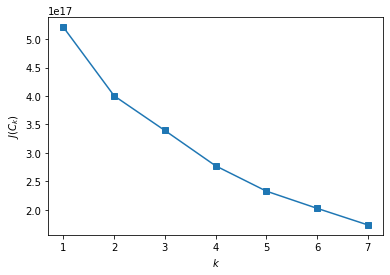

In [14]:
inertia = []
for k in range(1, 8):
    kmeans = KMeans(n_clusters=k, random_state=1).fit(X)
    inertia.append(np.sqrt(kmeans.inertia_))

plt.plot(range(1, 8), inertia, marker='s');
plt.xlabel('$k$')

plt.ylabel('$J(C_k)$');

In [15]:
# KMeans
kmeans = KMeans(n_clusters=5, random_state=0).fit(X)
df_19['kmeans'] = kmeans.fit_predict(X)

# Разобьем на df
df_19_0 = df_19[df_19['kmeans'] == 0]
df_19_1 = df_19[df_19['kmeans'] == 1]
df_19_2 = df_19[df_19['kmeans'] == 2]
df_19_3 = df_19[df_19['kmeans'] == 3]
df_19_4 = df_19[df_19['kmeans'] == 4]

df_19_0.shape, df_19_1.shape, df_19_2.shape, df_19_3.shape, df_19_4.shape

((1017, 10), (7, 10), (3, 10), (210, 10), (35, 10))

### df_19_0

In [16]:
X = df_19_0[['price_mean','mean', 'std', 'type_mean']]
y = df_19_0['count']

X['price_mean'] = X['price_mean']/X['price_mean'].mean()
X['mean'] = X['mean']/X['mean'].mean()
X['std'] = X['std']/X['std'].mean()
X['type_mean'] = X['type_mean']/X['type_mean'].mean()

# создаем пустую модель
skm_0 = lm.LinearRegression()

# обучим модель
skm_0.fit(X, y)

# и выведем параметры рассчитанной модели
print(skm_0.intercept_)
print(skm_0.coef_)

# Создадим прогноз 
df_19_0['predict'] = skm_0.predict(X)

# Создадим столбец ошибка
df_19_0['mistake'] = df_19_0['predict'] - df_19_0['count']
df_19_0['count'] = df_19_0['count'].astype(int)
df_19_0['mistake'] = df_19_0['mistake'].astype(float)
df_19_0.iloc[0:2]

-0.6562485494973647
[0.43237571 2.76030001 0.04769879 0.29886322]


,productType,typeModel,price_mean,mean,std,type_mean,count,predict,mistake,kmeans
0,Бельевица,Бельевица Moon,500.000000,0.125,0.353553,4.375,0,-0.218583,-0.218583,0
2,Бра,Бра ARTE,1806.666667,0.375,0.744024,3.125,0,0.602070,0.602070,0


### df_19_1

In [17]:
X = df_19_1[['price_mean','mean', 'std', 'type_mean']]
y = df_19_1['count']

X['price_mean'] = X['price_mean']/X['price_mean'].mean()
X['mean'] = X['mean']/X['mean'].mean()
X['std'] = X['std']/X['std'].mean()
X['type_mean'] = X['type_mean']/X['type_mean'].mean()

# создаем пустую модель
skm_1 = lm.LinearRegression()

# обучим модель
skm_1.fit(X, y)

# и выведем параметры рассчитанной модели
print(skm_1.intercept_)
print(skm_1.coef_)

# Создадим прогноз 
df_19_1['predict'] = skm_1.predict(X)

# Создадим столбец ошибка
df_19_1['mistake'] = df_19_1['predict'] - df_19_1['count']
df_19_1['count'] = df_19_1['count'].astype(int)
df_19_1['mistake'] = df_19_1['mistake'].astype(float)
df_19_1.iloc[0:2]

-4.131030003810956
[ -2.92821054  80.95222047 -19.25929644  -1.77654063]


,productType,typeModel,price_mean,mean,std,type_mean,count,predict,mistake,kmeans
96,Диван,Диван Каир,10833.40332,30.875,8.253787,471.375,53,50.043428,-2.956572,1
132,Диван,Диван Порту,15772.29000,12.500,3.422614,471.375,10,12.088529,2.088529,1


### df_19_2

In [18]:
X = df_19_2[['price_mean','mean', 'std', 'type_mean']]
y = df_19_2['count']

X['price_mean'] = X['price_mean']/X['price_mean'].mean()
X['mean'] = X['mean']/X['mean'].mean()
X['std'] = X['std']/X['std'].mean()
X['type_mean'] = X['type_mean']/X['type_mean'].mean()

# создаем пустую модель
skm_2 = lm.LinearRegression()

# обучим модель
skm_2.fit(X, y)

# и выведем параметры рассчитанной модели
print(skm_2.intercept_)
print(skm_2.coef_)

# Создадим прогноз 
df_19_2['predict'] = skm_2.predict(X)

# Создадим столбец ошибка
df_19_2['mistake'] = df_19_2['predict'] - df_19_2['count']
df_19_2['count'] = df_19_2['count'].astype(int)
df_19_2['mistake'] = df_19_2['mistake'].astype(float)
df_19_2.iloc[0:2]

101.26267663287993
[-11.56684996  28.11963181  58.34318061   4.17469424]


,productType,typeModel,price_mean,mean,std,type_mean,count,predict,mistake,kmeans
92,Диван,Диван Динс,34032.000000,37.750,10.236489,471.375,202,202.0,2.842171e-14,2
146,Диван,Диван Слипсон,40512.264403,19.875,3.522884,471.375,132,132.0,0.000000e+00,2


### df_19_3

In [19]:
X = df_19_3[['price_mean','mean', 'std', 'type_mean']]
y = df_19_3['count']

X['price_mean'] = X['price_mean']/X['price_mean'].mean()
X['mean'] = X['mean']/X['mean'].mean()
X['std'] = X['std']/X['std'].mean()
X['type_mean'] = X['type_mean']/X['type_mean'].mean()

# создаем пустую модель
skm_3 = lm.LinearRegression()

# обучим модель
skm_3.fit(X, y)

# и выведем параметры рассчитанной модели
print(skm_3.intercept_)
print(skm_3.coef_)

# Создадим прогноз 
df_19_3['predict'] = skm_3.predict(X)

# Создадим столбец ошибка
df_19_3['mistake'] = df_19_3['predict'] - df_19_3['count']
df_19_3['count'] = df_19_3['count'].astype(int)
df_19_3['mistake'] = df_19_3['mistake'].astype(float)
df_19_3.iloc[0:2]

-2.62669942835688
[ 0.79696936  9.4951984  -1.90522592  0.36832901]


,productType,typeModel,price_mean,mean,std,type_mean,count,predict,mistake,kmeans
1,Бельевица,Бельевица МК,1458.176471,4.25,3.284161,4.375,3,5.703733,2.703733,3
7,Бра,Бра Omnilux,1169.432000,1.25,1.581139,3.125,0,-0.741360,-0.741360,3


### df_19_4

In [20]:
X = df_19_4[['price_mean','mean', 'std', 'type_mean']]
y = df_19_4['count']

X['price_mean'] = X['price_mean']/X['price_mean'].mean()
X['mean'] = X['mean']/X['mean'].mean()
X['std'] = X['std']/X['std'].mean()
X['type_mean'] = X['type_mean']/X['type_mean'].mean()

# создаем пустую модель
skm_4 = lm.LinearRegression()

# обучим модель
skm_4.fit(X, y)

# и выведем параметры рассчитанной модели
print(skm_4.intercept_)
print(skm_4.coef_)

# Создадим прогноз 
df_19_4['predict'] = skm_4.predict(X)

# Создадим столбец ошибка
df_19_4['mistake'] = df_19_4['predict'] - df_19_4['count']
df_19_4['count'] = df_19_4['count'].astype(int)
df_19_4['mistake'] = df_19_4['mistake'].astype(float)
df_19_4.iloc[0:2]

10.132889885101292
[ 1.74057878 25.63983772  3.63253193  4.42559025]


,productType,typeModel,price_mean,mean,std,type_mean,count,predict,mistake,kmeans
87,Диван,Диван Гритон,40502.450549,11.375,3.113909,471.375,57,60.112247,3.112247,4
106,Диван,Диван Лайтси,26293.828571,8.750,3.918819,471.375,54,52.160562,-1.839438,4


### Объединим df_19_0 ... df_19_4

In [21]:
chunks = []
for chunk in [df_19_0, df_19_1, df_19_2, df_19_3, df_19_4]:    
    chunks.append(chunk)
df_19 = pd.concat(chunks, axis=0)

df_19.sort_values(by=['typeModel'], inplace=True)

df_19.head(3)

,productType,typeModel,price_mean,mean,std,type_mean,count,predict,mistake,kmeans
0,Бельевица,Бельевица Moon,500.000000,0.125,0.353553,4.375,0,-0.218583,-0.218583,0
1,Бельевица,Бельевица МК,1458.176471,4.250,3.284161,4.375,3,5.703733,2.703733,3
2,Бра,Бра ARTE,1806.666667,0.375,0.744024,3.125,0,0.602070,0.602070,0


In [22]:
df_19.kmeans.value_counts()

0    1017
3     210
4      35
1       7
2       3
Name: kmeans, dtype: int64

# kNN

In [23]:
from sklearn.neighbors import KNeighborsClassifier

In [24]:
X_train = df_19[['price_mean','mean', 'std', 'type_mean']]
y_train = df_19['kmeans']

X_train['price_mean'] = X_train['price_mean']/X_train['price_mean'].mean()
X_train['mean'] = X_train['mean']/X_train['mean'].mean()
X_train['std'] = X_train['std']/X_train['std'].mean()
X_train['type_mean'] = X_train['type_mean']/X_train['type_mean'].mean()

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

df_3.head(3)

,productType,typeModel,productNomenclature,productNomenclatureCode,count,price_mean,mean,std,count_type,type_mean
0,Бельевица,Бельевица МК,МК-140 бельевица,00-00015321,1,1500.0,0.125,0.353553,1,0.125
1,Буфет,Буфет Авиньон-1,Авиньон-1 буфет,DV-00018347,5,19190.0,0.625,0.916125,6,0.750
2,Буфет,Буфет Авиньон-2,Авиньон-2 буфет,DV-00018350,1,28990.0,0.125,0.353553,6,0.750


In [25]:
# Обучим knn классификатор на данных за 20 год
X_test = df_3[['price_mean','mean', 'std', 'type_mean']]

X_test['price_mean'] = X_test['price_mean']/X_test['price_mean'].mean()
X_test['mean'] = X_test['mean']/X_test['mean'].mean()
X_test['std'] = X_test['std']/X_test['std'].mean()
X_test['type_mean'] = X_test['type_mean']/X_test['type_mean'].mean()

df_3['knn'] = knn.predict(X_test)

In [26]:
df_3.knn.value_counts()

0    1977
3     426
4      17
1       9
2       2
Name: knn, dtype: int64

In [27]:
df_3.head(3)

,productType,typeModel,productNomenclature,productNomenclatureCode,count,price_mean,mean,std,count_type,type_mean,knn
0,Бельевица,Бельевица МК,МК-140 бельевица,00-00015321,1,1500.0,0.125,0.353553,1,0.125,0
1,Буфет,Буфет Авиньон-1,Авиньон-1 буфет,DV-00018347,5,19190.0,0.625,0.916125,6,0.750,0
2,Буфет,Буфет Авиньон-2,Авиньон-2 буфет,DV-00018350,1,28990.0,0.125,0.353553,6,0.750,0


In [28]:
# Разобьем на df
df_20_0 = df_3[df_3['knn'] == 0]
df_20_1 = df_3[df_3['knn'] == 1]
df_20_2 = df_3[df_3['knn'] == 2]
df_20_3 = df_3[df_3['knn'] == 3]
df_20_4 = df_3[df_3['knn'] == 4]

df_20_0.shape, df_20_1.shape, df_20_2.shape, df_20_3.shape, df_20_4.shape

((1977, 11), (9, 11), (2, 11), (426, 11), (17, 11))

### df_20_0

In [29]:
X = df_20_0[['price_mean','mean', 'std', 'type_mean']]

X['price_mean'] = X['price_mean']/X['price_mean'].mean()
X['mean'] = X['mean']/X['mean'].mean()
X['std'] = X['std']/X['std'].mean()
X['type_mean'] = X['type_mean']/X['type_mean'].mean()

# Создадим прогноз 
df_20_0['predict'] = skm_0.predict(X)
df_20_0.iloc[0:3]

,productType,typeModel,productNomenclature,productNomenclatureCode,count,price_mean,mean,std,count_type,type_mean,knn,predict
0,Бельевица,Бельевица МК,МК-140 бельевица,00-00015321,1,1500.0,0.125,0.353553,1,0.125,0,-0.078402
1,Буфет,Буфет Авиньон-1,Авиньон-1 буфет,DV-00018347,5,19190.0,0.625,0.916125,6,0.750,0,2.535430
2,Буфет,Буфет Авиньон-2,Авиньон-2 буфет,DV-00018350,1,28990.0,0.125,0.353553,6,0.750,0,0.746209


### df_20_1

In [30]:
X = df_20_1[['price_mean','mean', 'std', 'type_mean']]

X['price_mean'] = X['price_mean']/X['price_mean'].mean()
X['mean'] = X['mean']/X['mean'].mean()
X['std'] = X['std']/X['std'].mean()
X['type_mean'] = X['type_mean']/X['type_mean'].mean()

# Создадим прогноз 
df_20_1['predict'] = skm_1.predict(X)
df_20_1.iloc[0:3]

,productType,typeModel,productNomenclature,productNomenclatureCode,count,price_mean,mean,std,count_type,type_mean,knn,predict
313,Диван,Диван Сите-2,Сите-2 Barhat Rain диван,DV-00066679,49,20004.285714,6.125,4.549333,4701,587.625,1,-12.249709
1484,Матрас,Матрас Файн,Файн 160x200 матрас,DV-00006605,90,10358.000000,11.250,3.654743,600,75.000,1,17.789964
1678,Подушка,Подушка Варшава,Варшава подушка,00-00017388,80,1226.000000,10.000,4.242641,1330,166.250,1,16.361680


### df_20_2

In [31]:
X = df_20_2[['price_mean','mean', 'std', 'type_mean']]

X['price_mean'] = X['price_mean']/X['price_mean'].mean()
X['mean'] = X['mean']/X['mean'].mean()
X['std'] = X['std']/X['std'].mean()
X['type_mean'] = X['type_mean']/X['type_mean'].mean()

# Создадим прогноз 
df_20_2['predict'] = skm_2.predict(X)
df_20_2.iloc[0:3]

,productType,typeModel,productNomenclature,productNomenclatureCode,count,price_mean,mean,std,count_type,type_mean,knn,predict
515,Диван угловой,Диван угловой Порту,Порту Textile Grey диван угловой,00-00032904,260,19123.715385,32.500,6.633250,1379,172.375,2,177.717680
1711,Подушка,Подушка Декох40,Деко 40х40 подушка,00-00016917,201,1166.034826,25.125,5.792544,1330,166.250,2,182.948987


### df_20_3

In [32]:
X = df_20_3[['price_mean','mean', 'std', 'type_mean']]

X['price_mean'] = X['price_mean']/X['price_mean'].mean()
X['mean'] = X['mean']/X['mean'].mean()
X['std'] = X['std']/X['std'].mean()
X['type_mean'] = X['type_mean']/X['type_mean'].mean()

# Создадим прогноз 
df_20_3['predict'] = skm_3.predict(X)
df_20_3.iloc[0:3]

,productType,typeModel,productNomenclature,productNomenclatureCode,count,price_mean,mean,std,count_type,type_mean,knn,predict
49,Диван,Диван Айверс,Айверс Textile Blue диван,DV-00007727,2,23390.000000,0.250,0.462910,4701,587.625,3,-0.506441
50,Диван,Диван Айверс,Айверс Textile Green диван,DV-00007726,7,23847.142857,0.875,1.125992,4701,587.625,3,2.266457
54,Диван,Диван Айверс,Айверс диван,DV-00065034,1,30100.000000,0.125,0.353553,4701,587.625,3,-0.899481


### df_20_4

In [33]:
X = df_20_4[['price_mean','mean', 'std', 'type_mean']]

X['price_mean'] = X['price_mean']/X['price_mean'].mean()
X['mean'] = X['mean']/X['mean'].mean()
X['std'] = X['std']/X['std'].mean()
X['type_mean'] = X['type_mean']/X['type_mean'].mean()

# Создадим прогноз 
df_20_4['predict'] = skm_4.predict(X)
df_20_4.iloc[0:3]

,productType,typeModel,productNomenclature,productNomenclatureCode,count,price_mean,mean,std,count_type,type_mean,knn,predict
134,Диван,Диван Каир,Каир Textile Brown диван,ВК-00000448,40,12766.425000,5.000,2.507133,4701,587.625,4,44.729618
159,Диван,Диван Лени,Лени Velvet Light диван,00-00017595,37,22422.378378,4.625,2.615203,4701,587.625,4,44.225076
217,Диван,Диван Монти,Монти 156 диван,DV-00104871,34,32846.411765,4.250,2.964071,4701,587.625,4,44.076497


### Объединим df_20_0 ... df_20_2

In [34]:
chunks = []
for chunk in [df_20_0, df_20_1, df_20_2, df_20_3, df_20_4]:    
    chunks.append(chunk)
df_20 = pd.concat(chunks, axis=0)

df_20.sort_values(by=['typeModel'], inplace=True)
df_20.iloc[0:3]

df_20['predict'] = df_20['predict'].apply(round)
df_20.iloc[0:3]

,productType,typeModel,productNomenclature,productNomenclatureCode,count,price_mean,mean,std,count_type,type_mean,knn,predict
0,Бельевица,Бельевица МК,МК-140 бельевица,00-00015321,1,1500.0,0.125,0.353553,1,0.125,0,0
1,Буфет,Буфет Авиньон-1,Авиньон-1 буфет,DV-00018347,5,19190.0,0.625,0.916125,6,0.750,0,3
2,Буфет,Буфет Авиньон-2,Авиньон-2 буфет,DV-00018350,1,28990.0,0.125,0.353553,6,0.750,0,1


In [35]:
# Доли
df_20['share_nom'] = (df_20['count'] / df_20['count_type']) * 100
df_20['share_nom'] = df_20['share_nom'].apply(round)
df_20['week_48'] = df_20['predict'] * K_week1
df_20['week_49'] = df_20['predict'] * K_week2
df_20['week_48'] = df_20['week_48'].apply(round)
df_20['week_49'] = df_20['week_49'].apply(round)
df_20 = df_20[['productType', 'typeModel', 'productNomenclature',
               'productNomenclatureCode', 'share_nom', 'week_48', 'week_49']]
df_20.iloc[0:3]

,productType,typeModel,productNomenclature,productNomenclatureCode,share_nom,week_48,week_49
0,Бельевица,Бельевица МК,МК-140 бельевица,00-00015321,100,0,0
1,Буфет,Буфет Авиньон-1,Авиньон-1 буфет,DV-00018347,83,2,1
2,Буфет,Буфет Авиньон-2,Авиньон-2 буфет,DV-00018350,17,1,0


In [36]:
# Сохраним в csv
df_20.to_csv('data/weeks 48-49 ЧП.csv', sep=';', index=False, encoding='utf-8')